In [1]:
import os
import json

import math
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.expand_frame_repr', False)

from processing import process_search_terms as process

import spacy
import contractions
from unidecode import unidecode
from word2number import w2n

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

import pprint as pp

from importlib import reload
reload(process)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vonbecker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vonbecker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<module 'processing.process_search_terms' from '/Users/vonbecker/ML_Bootcamp_code/Docent_AI/explorer_ai/data/etl_pipeline/processing/process_search_terms.py'>

In [243]:
# import exhibit, gallery, and entity data

curr_path = os.getcwd()
cache_path = os.path.join(curr_path, 'cache/')

exhibits_json = os.path.join(cache_path, 'raw/exhibits.json')
galleries_json = os.path.join(cache_path, 'raw/galleries.json')

exhibits_ents_json = os.path.join(cache_path, 'entities/exhibits_merged.json')
galleries_ents_json = os.path.join(cache_path, 'entities/galleries_merged.json')

with open(exhibits_json, 'r') as file:
    exhibits = json.load(file)

print('{} exhibits imported'.format(len(exhibits)))

with open(galleries_json, 'r') as file:
    galleries = json.load(file)

print('{} galleries imported'.format(len(galleries)))

with open(exhibits_ents_json, 'r') as file:
    exhibits_ents = json.load(file)

print('{} exhibits with entities imported'.format(len(exhibits_ents)))

with open(galleries_ents_json, 'r') as file:
    galleries_ents = json.load(file)

print('{} galleries with entities imported'.format(len(galleries_ents)))

204 exhibits imported
6 galleries imported
186 exhibits with entities imported
6 galleries with entities imported


In [ ]:
# check out a random exhibit and the entities which relate to it

N = np.random.randint(len(exhibits))
pp.pprint(exhibits[N])
print('-' * 75)
pp.pp(exhibits_ents[exhibits[N]['id']])

In [ ]:
# check out a random gallery and the entities which relate to it

N = np.random.randint(len(galleries))
pp.pprint(galleries[N])
print('-' * 75)
pp.pp(galleries_ents[galleries[N]['id']])

In [87]:
# Define exhibit location codes:
#
# 1-6: Gallery 1-6
#  1b: Gallery 1, Black Box
#  3s: Gallery 3, Wattis Studio
#  6m: Gallery 6, Mezzanine
#   e: Entrance
#   c: Crossroads: Getting started
#   p: Plaza
#   a: Ray and Dagmar Dolby Atrium
#   b: Koret Foundation Bay Walk
#   j: SF Marina Jetty
#   X: Not currently on view

def get_code(location):
    if location == 'This exhibit is not currently on view.':
        return 'X'
    elif 'Gallery' in location:
        for n in range(6):
            code = str(n)
            if 'Gallery ' + code in location:
                if 'Mezzanine' in location:
                    return code + 'm'
                elif 'Black Box' in location:
                    return code + 'b'
                elif 'Wattis Studio' in location:
                    return code + 's'
                else:
                    return code
    elif 'Entrance' in location:
        return 'e'
    elif 'Crossroads' in location:
        return 'c'
    elif 'Plaza' in location:
        return 'p'
    elif 'Atrium' in location:
        return 'a'
    elif 'Bay Walk' in location:
        return 'b'
    elif 'jetty' in location.lower():
        return 'j'

# Remove markdown (?) language/symbols from 7 rows of the dataframe
# Removed text is the following:
#
# .btn-language{
#     position: absolute;
#     right: 0;
#     margin-right: 15px;
#     margin-left: 15px;
# }
#
# .dropdown-menu{
#     min-width: unset;
# }
#
# .dropdown-item{
#     text-decoration: none !important;
# }  Language   Español  繁體中文  Filipino
#

def remove_extra(text):
    if len(text) == 0:
        return None
    elif text.startswith('.btn-language'):
        return text.split('Filipino')[1].strip()
    else:
        return text

# preprocess keywords and phenomena
def process_keywords(list):
    processed = []
    for item in list:
        processed.append(process.preprocess(item, 'keyword'))
    return processed

def process_phenomena(list):
    processed = []
    for item in list:
        processed.append(process.preprocess(item, 'phenomenon'))
    return processed

In [291]:
# store exhibits data in dataframe with the following columns:
# 'exhibit_id', 'title', 'creator_name', 'created_date', 'location', 'about', 'collections', 'subjects', 'related'

exhibits_df = pd.DataFrame({'exhibit_id': pd.Series(dtype='str'),
                            'title': pd.Series(dtype='str'),
                            'alias': pd.Series(dtype='object'),
                            'creator_name': pd.Series(dtype='object'),
                            'created_date': pd.Series(dtype='str'),
                            'location': pd.Series(dtype='str'),
                            'about': pd.Series(dtype='str'),
                            'subjects': pd.Series(dtype='object'),
                            'related': pd.Series(dtype='object'),
                            'collections': pd.Series(dtype='object'),
                            })

for exhibit in exhibits:
    # drop non-English data and exhibits missing the 'title' field
    exhibit_id = exhibit['id']
    if exhibit_id in ['es', 'zht', 'fil'] or exhibit['title'] == '':
        continue

    else:
        # directly copy several key: value pairs
        these_keys = ['id',
                      'title',
                      'aliases',
                      'location',
                      'collection_id',
                      'related_id',
                      'description',
                      'whats_going_on',
                      'going_further',
                      'details',
                      'keywords',
                      'phenomena']
        this_data = {k: v for k, v in exhibit.items() if k in these_keys}

        # rename some keys
        this_data['exhibit_id'] = this_data.pop('id')
        this_data['collections'] = [this_data.pop('collection_id')]
        this_data['related'] = [this_data.pop('related_id')]
        this_data['alias'] = [this_data.pop('aliases').split(', ')]
        this_data['alias'] = [x for x in this_data['alias'] if x]   # why isn't this working?

        # code location data
        this_data['location'] = get_code(this_data['location'])

        # define 'about' as 'description' + 'whats_going_on' + 'going_further' + 'details'
        this_data['about'] = ' '.join([this_data.pop('description'),
                                       this_data.pop('whats_going_on'),
                                       this_data.pop('going_further'),
                                       this_data.pop('details')])

        # remove extra stuff from 'about' field
        this_data['about'] = remove_extra(this_data['about']).strip() or None

        # process 'keywords' and 'phenomena', then combine results and save to 'subjects'
        this_data['keywords'] = process_keywords(this_data['keywords'])
        this_data['phenomena'] = process_keywords(this_data['phenomena'])
        this_data['subjects'] = [this_data.pop('keywords') + this_data.pop('phenomena')]

        # copy entity 'byline' values into 'creator_name' and 'created_date'
        if 'byline' in exhibits_ents[exhibit_id].keys():
            byline_ents = exhibits_ents[exhibit_id]['byline']
            creator_name = [item['name'] for item in byline_ents if item['type'] == 'PERSON']
            created_date = [item['name'] for item in byline_ents if item['type'] == 'DATE']
        else:
            creator_name = []
            created_date = None

        this_data.update({
            'creator_name': [creator_name],
            'created_date': int(created_date[0]) if created_date else np.nan,
        })

        this_row = pd.DataFrame(data=this_data)
        this_row['created_date'] = this_row.apply(lambda row: row.created_date, axis=1)
        exhibits_df = pd.concat([exhibits_df, this_row], ignore_index=True)

exhibits_df.head(10)

,exhibit_id,title,alias,creator_name,created_date,location,about,subjects,related,collections
0,circles-of-magnetism,Circles of Magnetism,[],"[Erik Thogersen, Thomas Humphrey]",1999,2,None,"[magnet, magnetic field, navigation, electroma...","[black-sand, magnetic-fluid-patterns, magnetic...",[]
1,chaotic-pendulum,Chaotic Pendulum,[],[Ned Kahn],1986,a,Chaotic Pendulum contains a deceptively simple...,"[balance, center of gravity, chaos, pendulums,...","[pendulum-snake, drawing-board, coupled-pendul...",[turbulent-landscapes]
2,cafe-wall-illusion,Café Wall Illusion,[],"[Peter Richards, Richard Gregory]",NaN,c,None,"[eyes, color, patterns]",[],[]
3,chromoscope,Chromoscope,[Green Lips],[Chris Burda],NaN,c,None,"[color, color mixing]","[countless-colors, colored-shadows, monochroma...",[]
4,career-criminal,Career Criminal,[Prisoner's Dilemma],"[Mary Elizabeth Yarbrough, David Torgersen]",2014,X,None,[],"[sip-or-squirt, survival-game, team-snake, tex...",[science-of-sharing]
5,a-cell-in-motion,A Cell in Motion,[3D Cell Zoetrope],[Denise King],2017,4,Turn the crank and watch a moving cell model. ...,[cells movement animation],[],[cells-to-self]
6,chladni-singing,Chladni Singing,[Scream into Sand],"[Artist-in-Residence, Meara O'Reilly]",2013,X,Sand scattered on a large metal square vibrate...,"[sand, chladni, harmonics, natural frequency, ...","[sound-bite, seismograph, aeolian-harp, oscyli...","[artist-in-residence, listen]"
7,bronze-hand,Bronze Hand,[],[Jessica Strick],2005,X,None,[illusions],"[velvet-hands, tactile-dome, black-sand]",[mind]
8,christmas-tree-balls,Christmas Tree Balls,[Spherical Reflections],"[Robert Larue, Bob) Miller]",NaN,1,None,"[mirrors, blackness, close packing, image form...","[shadow-kaleidoscope, corner-reflector, all-ey...",[seeing-the-light]
9,buckyball,Buckyball,[],[Leo Villareal],2016,p,Inspired by the shape first explored by futuri...,[],"[cubatron-core, lumen-illusion]",[]


In [131]:
# investigate presense of missing data

N = len(exhibits_df)

def count_perc(count):
    return count, count/N

print('Dataframe exhibits_df contains {} rows\n'.format(N))

missing_data = {
    'exhibit_id': exhibits_df['exhibit_id'].isnull().sum(),
    'title': exhibits_df['title'].isnull().sum(),
    'alias': exhibits_df['alias'].apply(lambda x: 1 if x == [''] else 0).sum(),   # why isn't this working???
    'creator_name': exhibits_df['creator_name'].apply(lambda x: 1 if len(x) == 0 else 0).sum(),
    'created_date': exhibits_df['created_date'].isnull().sum(),
    'location':exhibits_df['location'].isnull().sum(),
    'about': exhibits_df['about'].isnull().sum(),
    'subjects': exhibits_df['subjects'].apply(lambda x: 1 if len(x) == 0 else 0).sum(),
    'collections': exhibits_df['collections'].apply(lambda  x: 1 if len(x) == 0 else 0).sum(0),
    'related': exhibits_df['related'].apply(lambda x: 1 if len(x) == 0 else 0).sum(),
}

label = 'Missing data by column label'
print(label + '\n' + '='*len(label))
for k, v in missing_data.items():
    val, per = count_perc(v)
    print(f'{k}: {val}, {per:0.2%}')

Dataframe exhibits_df contains 183 rows

Missing data by column label
exhibit_id: 0, 0.00%
title: 0, 0.00%
alias: 98, 53.55%
creator_name: 22, 12.02%
created_date: 33, 18.03%
location: 19, 10.38%
about: 40, 21.86%
subjects: 54, 29.51%
collections: 70, 38.25%
related: 25, 13.66%


In [129]:
# 'exhibit_id' and 'title' are unique

exhibits_df[['exhibit_id', 'title']].nunique()

exhibit_id    183
title         183
dtype: int64

In [292]:
# store galleries data in dataframe with the following columns:
# 'gallery_id', 'title', 'about', 'curator_statement'

galleries_df = pd.DataFrame({'gallery_id': pd.Series(dtype='str'),
                             'title': pd.Series(dtype='str'),
                             'about': pd.Series(dtype='str'),
                             'curator_statement': pd.Series(dtype='str'),
                             })

for gallery in galleries:
    # directly copy several key: value pairs
    these_keys = ['id',
                  'title',
                  'tagline',
                  'description',
                  'curator_statement']
    this_data = {k: v for k, v in gallery.items() if k in these_keys}

    # rename some keys
    this_data['gallery_id'] = this_data.pop('id')

    # define 'about' as 'tagline' + 'description'
    this_data['about'] = ' '.join([this_data.pop('tagline'),
                                   this_data.pop('description')])

    this_row = pd.DataFrame(data=this_data, index=[0])
    galleries_df = pd.concat([galleries_df, this_row], ignore_index=True)

galleries_df.head(10)

,gallery_id,title,about,curator_statement
0,gallery-2,Gallery 2: Tinkering,Explore your creativity and our curious contra...,"A tall, fanciful, interactive Tinkerer’s Clock..."
1,gallery-1,Bernard and Barbro Osher Gallery 1: Human Phen...,"Experiment with thoughts, feelings, and social...",The experiences in the Osher Gallery focus on ...
2,gallery-6,Fisher Bay Observatory Gallery 6: Observing La...,"Uncover the history, geography, and ecology of...","This second-floor, indoor/outdoor exhibition s..."
3,gallery-3,Bechtel Gallery 3: Seeing & Reflections,"Experiment with light, mirrors, and bubbles. O...",Bechtel Gallery 3 is the heart of the Explorat...
4,gallery-4,Gordon and Betty Moore Gallery 4: Living Systems,Explore life from DNA and cells to organisms a...,Gallery 4 fosters an appreciation of the livin...
5,gallery-5,Gallery 5: Outdoor Exhibits,"Explore winds, tides, and natural phenomena. I...",The guiding principle of the Gallery 5 is to s...


In [293]:
# load the spacy english language model and define stopwords

nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print(stopwords)  # which of these stopwords should be ignored? (numbers can be igored with pos)

{'n’t', '’d', 'bottom', 'anywhere', 'less', 'whereafter', 'have', 'side', 'wherever', 'twenty', 'something', 'the', 'may', 'are', 'without', 'someone', 'hers', 'us', 'its', '‘ll', 'sometime', 'except', 'various', 'which', 'same', 'give', 'we', 'beyond', '’m', 'whenever', '‘d', 'under', 'few', 'see', 'whereby', 'into', '‘re', 'four', 'perhaps', 'somehow', 'much', 'fifty', 'part', 'because', 'eleven', 'once', "'d", 'a', 'done', 'whereas', 'hereupon', 'please', 'such', 'became', 'seemed', 'else', 'he', 'quite', 'around', 'so', 'formerly', 'although', 'doing', 'latter', 'always', '‘m', 'down', 'rather', 'take', 'full', 'otherwise', 'most', 'then', 'within', 'our', 'whereupon', 'elsewhere', 'many', 'by', 'over', 'back', 'herein', 'thereby', 'eight', 'beforehand', 'whither', 'anyway', 'do', 'ourselves', 'were', 'each', 'from', 'or', 'and', 'there', 'afterwards', 'last', 'however', 'cannot', 'itself', 'top', 'toward', 'where', 'anyhow', 'yourselves', 'only', 'seem', 'already', 'one', 'none', 

In [245]:
# define the text processing pipeline

# deselected_stop_words = ['one', 'two']
# for w in deselected_stop_words:
#     nlp.vocab[w].is_stop = False

def remove_whitespace(text):
    text = ' '.join(text.strip().split())
    return text

def remove_accents(text):
    text = unidecode(text)
    return text

def expand_contractions(text):
    text = contractions.fix(text)
    return text

def preprocess(text, accented_chars=True, contractions=True,
                       convert_num=True, whitespace=True,
                       lemmatization=True, lowercase=True, punctuation=True,
                       remove_num=False, special_chars=True, stop_words=True):
    if whitespace:
        text = remove_whitespace(text)
    if accented_chars:
        text = remove_accents(text)
    if contractions:
        text = expand_contractions(text)
    if lowercase:
        text = text.lower()

    doc = nlp(text)
    clean_text = []

    for token in doc:
        flag = False
        this_token = token.text
        if stop_words and token.is_stop and token.pos_ != 'NUM':  # removes stop words which aren't numbers
            flag = True
        elif punctuation and token.pos_ == 'PUNCT':  # removes punctuation
            flag = True
        elif special_chars and token.pos_ == 'SYM':  # removes special characters
            flag = True
        elif remove_num and (token.pos_ == 'NUM' or token.text.isnumeric()):  # removes numbers
            flag = True
        if convert_num and token.pos_ == 'NUM' and not flag:  # converts number words to numerals
            try:
                this_token = w2n.word_to_num(token.text)
            except ValueError:
                pass
        if lemmatization and token.lemma_ != "-PRON-" and not flag:  # gets lemmas, ignoring pronouns
            this_token = token.lemma_
        if this_token != "" and not flag:  # appends (converted and/or lemmatized) unflagged tokens to clean_text
            clean_text.append(this_token)

    return clean_text

In [246]:
# import data and store in a dataframe with columns 'article_id', 'source', 'title', and 'pre_heading_text'

curr_path = os.getcwd()
data_path = os.path.join(curr_path, '../knowledgebase/encyclopedia/prehead_text/')

articles_df = pd.DataFrame({'article_id': pd.Series(dtype='str'),
                            'source_code': pd.Series(dtype='int'),
                            'title': pd.Series(dtype='str'),
                            'text': pd.Series(dtype='str')})

for filename in os.listdir(data_path):
    if filename.startswith('.'):
        continue
    filepath = os.path.join(data_path, filename)
    with open(filepath, 'r') as infile:
        new_data = json.load(infile)
        new_df = pd.DataFrame(data=new_data, index=[0])
    articles_df = pd.concat([articles_df, new_df], ignore_index=True)

articles_df = articles_df.rename(columns={'text': 'pre_heading_text'})

# add a column to the dataframe which stores the processed text (a list of tokens)
articles_df['tokens'] = articles_df['pre_heading_text'].apply(lambda text: preprocess(text))

print('{} articles imported'.format(len(articles_df)))

576 articles imported


In [264]:
# investigate distribution of article length (number of characters) by source:
#  1: Avanced
# 31: Intermediate
# 45: Concise

articles_df['article_len'] = articles_df['pre_heading_text'].apply(lambda text: len(text))
print('Article length (characters):\n{}\n'.format(articles_df.groupby(['source_code'])['article_len'].describe()))

Article length (characters):
             count    mean     std    min    25%     50%     75%      max
source_code                                                              
1           347.00 1932.86 1627.46  65.00 769.00 1496.00 2549.50 10856.00
31           76.00 1546.58 1107.27 309.00 742.00 1161.50 2081.75  4850.00
45          153.00  765.56  302.39 268.00 567.00  676.00  886.00  2294.00



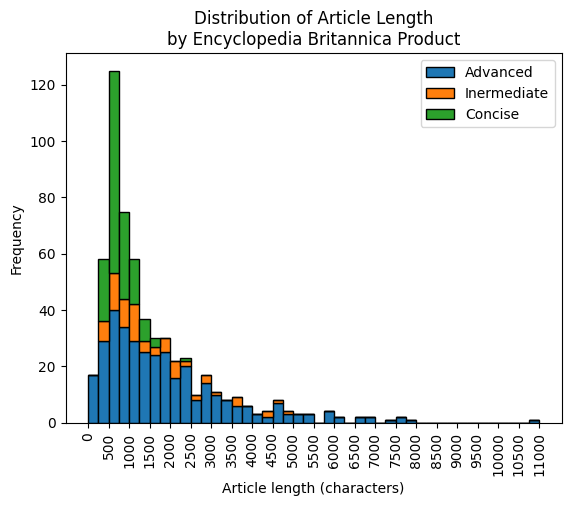

In [283]:
# plot distirubtion of article length by source

def round_up(num, delta):
    num = math.ceil(num / delta) * delta
    return num

def make_int(values, d):
    return np.arange(0, round_up(values.max(), d) + d, d, dtype=int)

delta = 250
endpoints = make_int(articles_df['article_len'], delta)
xticks = make_int(articles_df['article_len'], 2 * delta)

plt.hist([articles_df['article_len'][articles_df.source_code == 1],
          articles_df['article_len'][articles_df.source_code == 31],
          articles_df['article_len'][articles_df.source_code == 45]],
         histtype='bar', stacked=True, label=['Advanced', 'Inermediate', 'Concise'],
         bins=endpoints, edgecolor='black')

plt.xlabel('Article length (characters)')
plt.xticks(xticks, rotation='vertical')
plt.ylabel('Frequency')
plt.title('Distribution of Article Length\nby Encyclopedia Britannica Product')
plt.legend()
plt.show()

In [286]:
# investigate the distribution of the number of tokens (post-processing) per article by source:
#  1: Avanced
# 31: Intermediate
# 45: Concise

num_tokens = articles_df['tokens'].str.len()
articles_df['num_tokens'] = articles_df['tokens'].apply(lambda lst: len(lst))
print('Number of tokens (post-processing):\n{}\n'.format(articles_df.groupby(['source_code'])['num_tokens'].describe()))

Number of tokens (post-processing):
             count   mean    std   min   25%    50%    75%    max
source_code                                                      
1           347.00 163.81 136.30  7.00 66.00 126.00 214.00 830.00
31           76.00 134.04 100.79 29.00 62.75  96.00 171.25 433.00
45          153.00  68.00  28.14 23.00 49.00  61.00  79.00 208.00



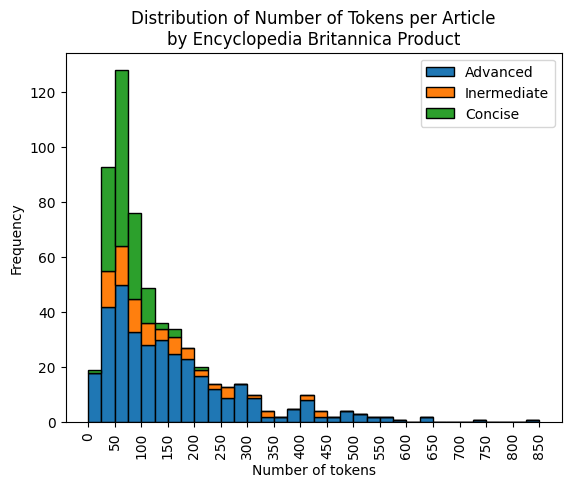

In [290]:
# plot distirubtion of number of tokens per article by source

delta = 25
endpoints = make_int(articles_df['num_tokens'], delta)
xticks = make_int(articles_df['num_tokens'], 2 * delta)

plt.hist([articles_df['num_tokens'][articles_df.source_code == 1],
          articles_df['num_tokens'][articles_df.source_code == 31],
          articles_df['num_tokens'][articles_df.source_code == 45]],
         histtype='bar', stacked=True, label=['Advanced', 'Inermediate', 'Concise'],
         bins=endpoints, edgecolor='black')

plt.xlabel('Number of tokens')
plt.xticks(xticks, rotation='vertical')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Tokens per Article\nby Encyclopedia Britannica Product')
plt.legend()
plt.show()

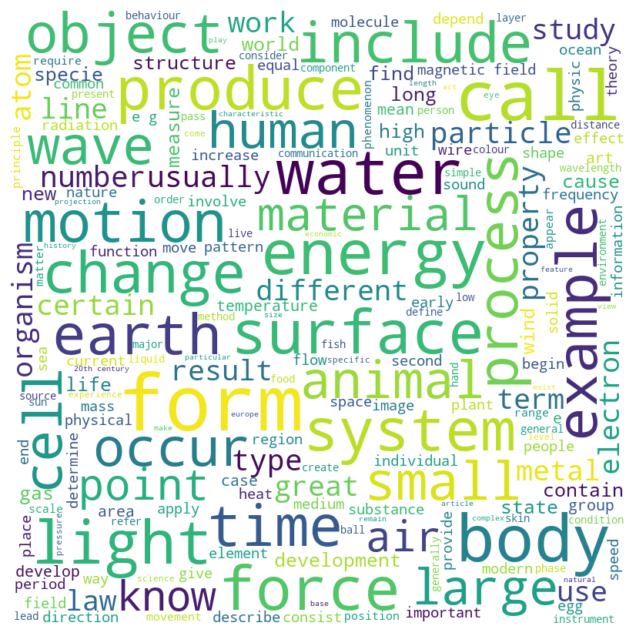

In [241]:
# visualize wordcloud of all (pre-processed) tokens across all articles

list_of_lists = articles_df['tokens'].tolist()
token_list = [token for sublist in list_of_lists for token in sublist]
token_str = ' '.join(token_list)

wordcloud = WordCloud(width = 800,
                      height = 800,
                      background_color='white',
                      min_font_size=10,
                      max_font_size=100).generate(token_str)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()